In [1]:
import os
import time
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
from skimage.transform import resize
from photutils import CircularAperture, CircularAnnulus

import galsim

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'legend.fontsize': 14})
rcParams.update({'legend.title_fontsize': 16})
rcParams.update({'axes.titlesize': 16})

from utils import *

In [2]:
############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
mask_strip = True
draw = True
save = False

dir_name = "./run"
if save:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    else:
        if len(os.listdir(dir_name)) != 0:
            while os.path.exists(dir_name):
                dir_name = input("'%s' already existed. Enter a directory name for saving:"%dir_name)
            os.makedirs(dir_name)
    print("Results will be saved in %s"%dir_name)

    
# Image Parameter
image_size = 400
n_star = 350
pixel_scale = 2.5                                # arcsec/pixel
psf_pixel_scale = 1.5                            # arcsec/pixel

# PSF Parameters
beta_psf = 3                                     # moffat beta, in arcsec
fwhm = 2.2 * pixel_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n = 2.7                     # true power index
frac = 0.15                 # fraction of power law component
theta_t = 6.                # radius at which power law is flattened, in arcsec

theta_t_pix = theta_t/pixel_scale          # in pix
theta_t_psf_pix = theta_t/psf_pixel_scale  # in pix
a = (theta_t_psf_pix)**n                   # normalization

noise_variance = 25                        # sky variance
mu = 884                                   # sky mean
sigma = np.sqrt(noise_variance)            # sky stddev

Maximum R: 192 (pix)
Maximum R: 192 (pix)
Maximum R: 36 (pix)


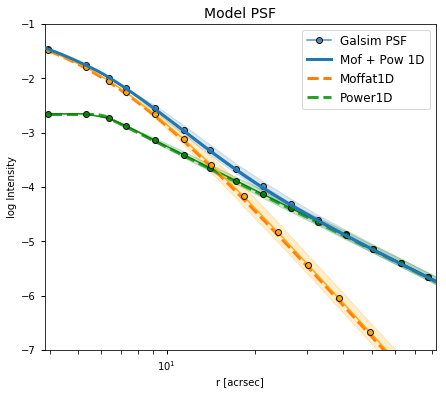

In [3]:
############################################
# Setup PSF
############################################

def Generate_PSF_pow_Galsim(contrast, n=n, psf_scale=psf_pixel_scale, 
                            psf_size=None, min_psf_size=None, max_psf_size=None,
                            x_interpolant="lanczos3", k_interpolant="lanczos3"):
    if psf_size is None:
        a = (theta_t/psf_scale)**n
        opt_psf_size = 2 * int((contrast * a) ** (1./n))
        opt_psf_size = round_good_fft(opt_psf_size)
        psf_size = max(min_psf_size, min(opt_psf_size, max_psf_size))

    cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
    yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]

    psf_model = trunc_power2d(xx_psf, yy_psf, n, cen=cen_psf, theta0=theta_t/psf_scale, I_theta0=1) 
    image_psf = galsim.ImageF(psf_model)
    
    psf_pow = galsim.InterpolatedImage(image_psf, flux=1, scale=psf_scale,
                                       x_interpolant=x_interpolant, k_interpolant=k_interpolant)
    return psf_pow, psf_size


# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_pow_1, psf_size_1 = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_size=512,
                                                psf_scale=psf_pixel_scale)
psf_pow_2, psf_size_2 = Generate_PSF_pow_Galsim(contrast=1e5, n=n,
                                                psf_size=image_size*2, 
                                                psf_scale=psf_pixel_scale)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-6)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

if draw:
    frac = 0.15
    star_psf_2 = (1-frac) * psf_mof + frac * psf_pow_2 
    
    img_pow_2 = psf_pow_2.drawImage(scale=pixel_scale, method="no_pixel").array
    img_mof = psf_mof.drawImage(scale=pixel_scale, method="fft").array
    img_gs_2 = star_psf_2.drawImage(scale=pixel_scale, method="no_pixel").array
    
    plt.figure(figsize=(7,6))
    r = np.logspace(0.1,2.5,100)
    C_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 

    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / C_mof2Dto1D
    C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / C_pow2Dto1D

    r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5,  
                                                             xunit="arcsec", yunit="intensity", label="Galsim PSF")
    r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(frac*img_pow_2, pix_scale=pixel_scale, seeing=2.5, 
                                                             xunit="arcsec", yunit="intensity", color="g")
    r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d((1-frac)*img_mof, pix_scale=pixel_scale, seeing=2.5, 
                                                             xunit="arcsec", yunit="intensity", color="orange")

    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1 + comp2 * frac), ls="-", lw=3, label="Mof + Pow 1D",zorder=5)
    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1), ls="--", lw=3, label="Moffat1D",zorder=1)
    plt.plot(r*pixel_scale, np.log10(comp2 * frac), ls="--",lw=3,  label="Power1D")

    plt.xscale("log")
    plt.axvline(theta_t_pix,color="k",ls="--")
    plt.title("Model PSF",fontsize=14)

    plt.legend(fontsize=12)
    plt.ylim(-7,-1)
    if save:
        plt.savefig("%s/ModelPSF.png"%dir_name,dpi=150)
        plt.close()

Generate noise background w/ stddev = 5.
Generate base image of stars w/ flux < 4.2e+04.
Total Time: 0.136s
Generate the truth image.
Total Time: 8.500s


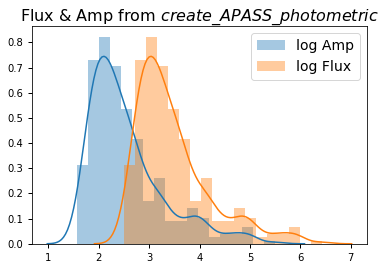

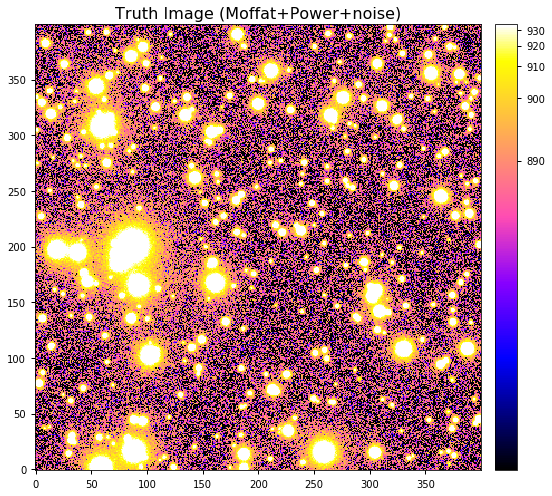

In [4]:
############################################
# Setup Image
############################################

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Generate randomn star positions
np.random.seed(88)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[(SE_cat_full.FLAGS<8)]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(512)
Fluxs = Flux_Auto_SE.sample(n=n_star).values

# Fluxs to Astropy Moffat Amplitude (pixel)
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Fluxs])

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 5e4
F_verybright = 8e5
bright = Fluxs > F_bright
verybright = Fluxs > F_verybright

if draw:
    import seaborn as sns
    sns.distplot(np.log10(Amps),label="log Amp")
    sns.distplot(np.log10(Fluxs),label="log Flux")
    plt.title("Flux & Amp from $create{\_}APASS{\_}photometric$")
    plt.legend()

       
def get_center_offset(pos):
    x_pos, y_pos = pos[0] + 1, pos[1] + 1 
    x_nominal = x_pos + 0.5
    y_nominal = y_pos + 0.5
    ix_nominal = int(math.floor(x_nominal+0.5))
    iy_nominal = int(math.floor(y_nominal+0.5))
    dx = x_nominal - ix_nominal
    dy = y_nominal - iy_nominal
    offset = galsim.PositionD(dx,dy)
    return (ix_nominal, iy_nominal), offset       

# Setup the noise background
def make_noise_image(image_size, noise_var, random_seed=42):
    noise_image = galsim.ImageF(image_size, image_size)
    rng = galsim.BaseDeviate(random_seed)
    gauss_noise = galsim.GaussianNoise(rng, sigma=math.sqrt(noise_var))
    noise_image.addNoise(gauss_noise)  
    return noise_image.array

print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, noise_variance)
    
# Setup the base image for faint stars (Moffat only):
def make_base_image(image_size, star_pos, Fluxs):
    start = time.time()
    full_image0 = galsim.ImageF(image_size, image_size)
    for k, (pos, flux) in enumerate(zip(star_pos, Fluxs)): 

        star = psf_mof.withFlux(flux)
        (ix_nominal, iy_nominal), offset = get_center_offset(pos)

        stamp = star.drawImage(scale=pixel_scale, offset=offset, method='no_pixel')
        stamp.setCenter(ix_nominal,iy_nominal)

        bounds = stamp.bounds & full_image0.bounds
        full_image0[bounds] += stamp[bounds]

    image_gs0 = full_image0.array
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    return image_gs0

print("Generate base image of stars w/ flux < %.2g."%(Fluxs[~bright].max()))
image_gs0 = make_base_image(image_size, star_pos=star_pos[~bright], Fluxs=Fluxs[~bright])

# Make the truth image to be fitted (Moffat+power):
def make_truth_image(image_size, star_pos, Fluxs, noise,
                     method="Real", saturation=4.5e4):
    start = time.time()
    
    if method == "Galsim":
        
        full_image = galsim.ImageF(image_size, image_size)
        for k, (pos, flux) in enumerate(zip(star_pos, Fluxs)): 

            if flux < 1e3:  # totally faint stars, just assume truth is mofffat
                psf_star = psf_mof
            elif flux < F_verybright: 
                psf_star = (1-frac) * psf_mof + frac * psf_pow_1
            else:
                psf_star = (1-frac) * psf_mof + frac * psf_pow_2

            star = psf_star.withFlux(flux)
            (ix_nominal, iy_nominal), offset = get_center_offset(pos)

            stamp = star.drawImage(scale=pixel_scale, offset=offset, method='no_pixel')
            stamp.setCenter(ix_nominal,iy_nominal)

            bounds = stamp.bounds & full_image.bounds
            full_image[bounds] += stamp[bounds]

        image_gs = full_image.array
        image = image_gs.copy()

    elif method == "Real":
        
        moffat2d_s = [models.Moffat2D(amplitude=amp, x_0=x0, y_0=y0, gamma=gamma_pix, alpha=beta_psf) 
                      for (amp, (x0,y0)) in zip(Amps, star_pos)]
        power2d_s = [lambda xx, yy, flux=flux, cen=cen: trunc_power2d(xx, yy, n, cen=cen, theta0=theta_t_pix, 
                                                                      I_theta0=power2d_Flux2Amp(n, theta_t_pix, frac*flux))
                     for (flux, cen) in zip(Fluxs, star_pos)]

        image_real = np.sum([m2d(xx,yy) + p2d(xx,yy) 
                                for (m2d,p2d) in zip(moffat2d_s, power2d_s)], axis=0) 
        image = image_real.copy()
        
    image += mu + noise
    image[image>saturation] = saturation
        
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    
    return image

print("Generate the truth image.")
image = make_truth_image(image_size, star_pos=star_pos, Fluxs=Fluxs, 
                         noise=noise_image, method="Real")

if draw:
    plt.figure(figsize=(8,7))
    im = plt.imshow(image, vmin=mu, vmax=mu+10*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    plt.title("Truth Image (Moffat+Power+noise)")
    colorbar(im)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Truth.png"%dir_name,dpi=150) 
        plt.close()

Mask inner regions of stars (threshold: S/N = 2.5)
Use sky strips crossing very bright stars


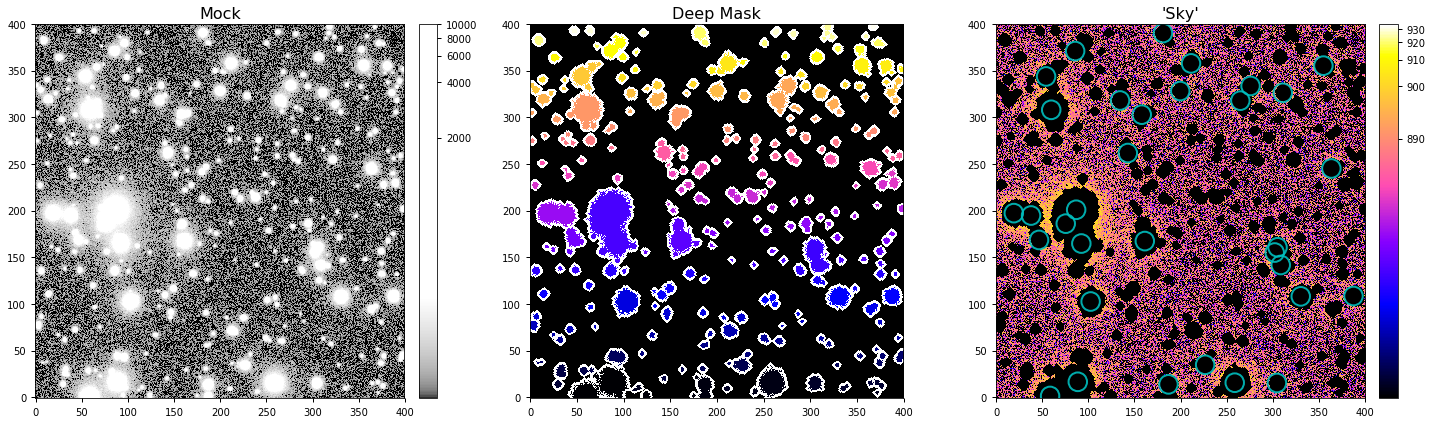

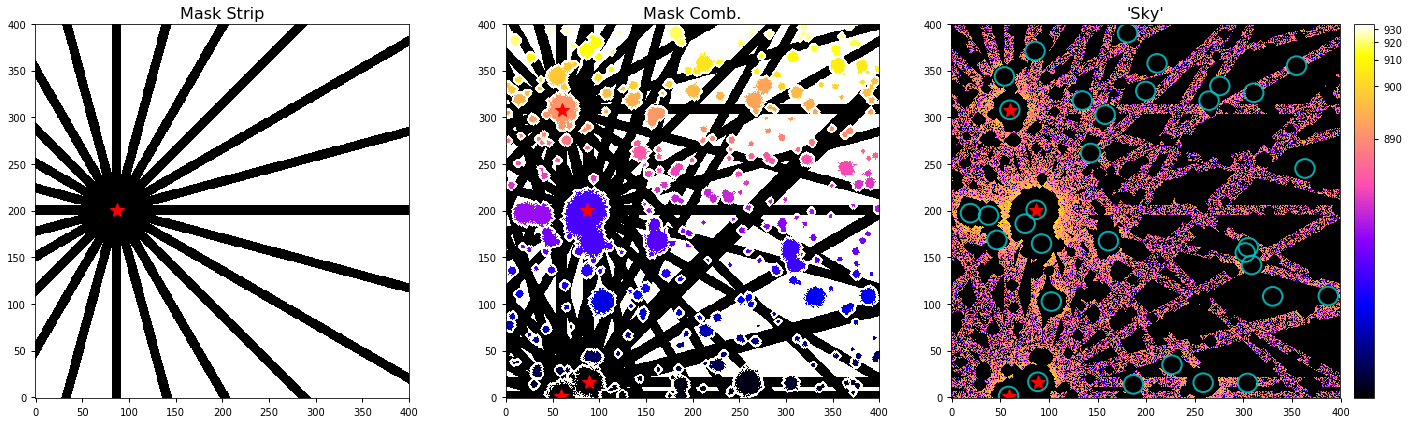

In [5]:
############################################
# Make Mask
############################################

# Make mask map for fitting
print("Mask inner regions of stars (threshold: S/N = 2.5)")
mask_deep, seg_map = make_mask_map(image, sn_thre=2.5, b_size=25, n_dilation=3)

if draw:
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm1, vmin=mu, vmax=1e4, aspect='auto')
    ax1.set_title("Mock")
    colorbar(im1)

    ax2.imshow(seg_map, origin="lower", cmap="gnuplot2")
    ax2.set_title("Deep Mask")

    image2 = image.copy()
    image2[mask_deep] = 0
    im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm2, vmin=mu, vmax=mu+10*sigma, origin='lower', aspect='auto') 
    ax3.set_title("'Sky'")
    colorbar(im3)

    aper = CircularAperture(star_pos[bright], r=10)
    aper.plot(color='c',lw=2,label="",alpha=0.9, ax=ax3)

    plt.tight_layout()
    if save:
        plt.savefig("%s/Mask.png"%dir_name,dpi=150)
        plt.close()

if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s = make_mask_strip(image_size, star_pos[verybright], Fluxs[verybright], width=5, n_strip=12)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    seg_comb = seg_map.copy()
    seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
    mask_comb = (seg_comb!=0)

    if draw:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
        ax1.imshow(mask_strip_s[-1], origin="lower", cmap="gray_r")
        ax1.plot(star_pos[Fluxs.argsort()][-1][0], star_pos[Fluxs.argsort()][-1][1], "r*",ms=15)
        ax1.set_title("Mask Strip")

        ax2.imshow(seg_comb, origin="lower", cmap="gnuplot2")
        ax2.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax2.set_title("Mask Comb.")

        image3 = image.copy()
        image3[mask_comb] = 0
        im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=mu, vmax=mu+10*sigma, origin='lower') 
        ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax3.set_title("'Sky'")
        colorbar(im3)
        
        aper = CircularAperture(star_pos[bright], r=10)
        aper.plot(color='c',lw=2,label="",alpha=0.9, ax=ax3)

        plt.tight_layout()
        if save:
            plt.savefig("%s/Mask_strip.png"%dir_name,dpi=150)
            plt.close()

Test of making mock image.

Total Time: 0.322s


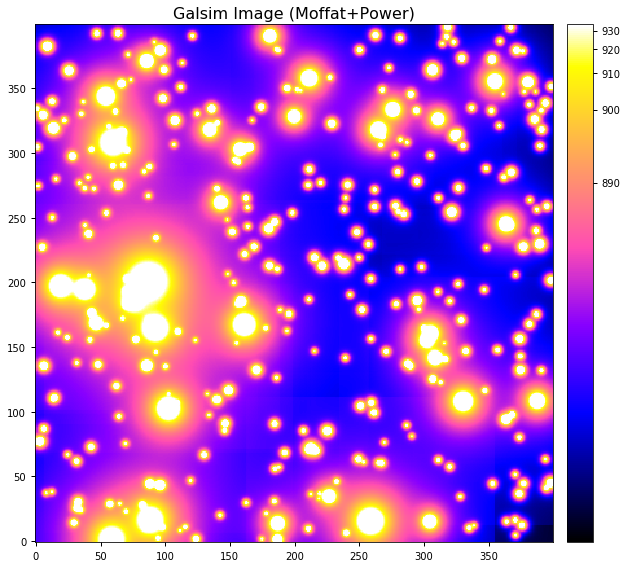

In [7]:
############################################
# Make Mock Image
############################################

def generate_image_galsim(frac, n, mu, sigma, 
                          image_size=image_size, 
                          bright=bright, verybright=verybright,
                          min_psf_size=32, max_psf_size=512):
        
    psf_pow, psf_size = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_scale=pixel_scale, psf_size=None,  
                                                min_psf_size=min_psf_size, max_psf_size=max_psf_size,
                                                x_interpolant="linear", k_interpolant="linear")
    
    full_image = galsim.ImageF(image_size, image_size)
       
    for k, (pos, flux) in enumerate(zip(star_pos[bright&(~verybright)], Fluxs[bright&(~verybright)])): 

        psf_star = (1-frac) * psf_mof + frac * psf_pow
        star = psf_star.withFlux(flux)
              
        (ix_nominal, iy_nominal), offset = get_center_offset(pos)

        stamp = star.drawImage(nx=psf_size, ny=psf_size, scale=pixel_scale, offset=offset, method='no_pixel')
        stamp.setCenter(ix_nominal, iy_nominal)

        bounds = stamp.bounds & full_image.bounds
        full_image[bounds] += stamp[bounds]
        
    image_gs = full_image.array + image_gs0 # Add the faint star base
    
    for k, (pos, flux) in enumerate(zip(star_pos[verybright], Fluxs[verybright])):
        p2d_vb = trunc_power2d(xx, yy, n, cen=(pos[0],pos[1]),
                               theta0=theta_t_pix, I_theta0=frac*flux * (n-2)/n /theta_t_pix**2/np.pi)
        image_gs += p2d_vb

    image = image_gs.copy() + mu

    return image

if draw:
    start = time.time()
    image_tri = generate_image_galsim(frac=frac, n=n, mu=mu, sigma=sigma)
    end = time.time()
    print("Test of making mock image.")
    print("\nTotal Time: %.3fs"%(end-start))

    plt.figure(figsize=(9,8))
    im = plt.imshow(image_tri, vmin=mu, vmax=mu+10*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    plt.title("Galsim Image (Moffat+Power)")
    colorbar(im)
    plt.tight_layout()   
    if save:
        plt.savefig("%s/Mock.png"%dir_name,dpi=150)
        plt.close()

Truths:  [-8.24e-01  2.70e+00  8.84e+02  5.00e+00]


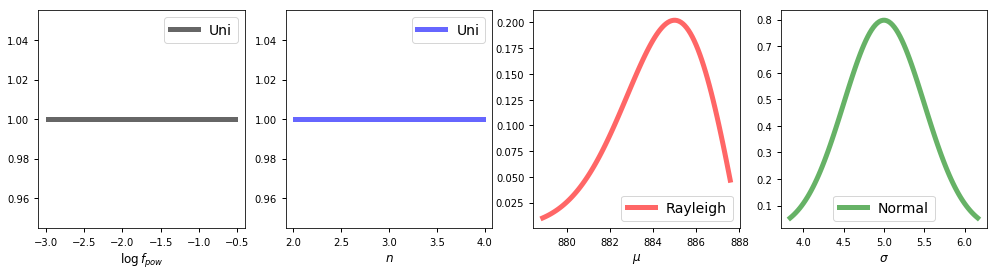

In [8]:
############################################
# Priors and Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp

truths = np.log10(frac), n, mu, sigma
labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
print("Truths: ", np.around(truths, 3))

def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 2.5 - 3 # frac : 0.001-0.5
    v[1] = u[1] * 2 + 2  # n : 2-4
    v[2] = 888 - stats.rayleigh.ppf(u[2], loc=0, scale=3.)  # mu
    v[3] = stats.norm.ppf(u[3], loc=5, scale=0.5)  # sigma : N(5, 0.5)
    return v

if draw:
    dist1=stats.uniform()
    dist2=stats.rayleigh(loc=0, scale=3)
    dist3=stats.norm(loc=5, scale=0.5)

    x0,x1,x2,x3 = [np.linspace(d.ppf(0.01), d.ppf(0.99), 100) for d in (dist1,dist1,dist2,dist3)]

    fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(17,4))
    ax0.plot((x0 * 2.5 - 3), dist1.pdf(x0),'k-', lw=5, alpha=0.6, label='Uni')
    ax1.plot(x1*2+2, dist1.pdf(x1),'b-', lw=5, alpha=0.6, label='Uni')
    ax2.plot(888-x2, dist2.pdf(x2),'r-', lw=5, alpha=0.6, label='Rayleigh')
    ax3.plot(x3, dist3.pdf(x3),'g-', lw=5, alpha=0.6, label='Normal')
    for ax, xlab in zip((ax0,ax1,ax2,ax3), ["$\log\,f_{pow}$", "$n$", "$\mu$", "$\sigma$"]):
        ax.legend()
        ax.set_xlabel(xlab, fontsize=12)
    if save:
        plt.savefig("%s/Prior.png"%dir_name,dpi=150)
        plt.close('all')

if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike(v):
    logfrac, n, mu, sigma = v
    frac = 10**logfrac
    
    image_tri = generate_image_galsim(frac, n, mu, sigma, image_size=image_size)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


In [9]:
############################################
# Fitting
############################################

def Run_Nested_Fitting(loglike=loglike, 
                       prior_transform=prior_transform, 
                       ndim=4, truths=truths, 
                       nlive_init=200, nlive_batch=100, maxbatch=3,
                       print_progress=True):
        
    with mp.Pool(processes=n_cpu) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        start = time.time()
        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, nlive_batch=nlive_batch, maxbatch=maxbatch,
                             print_progress=print_progress, dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
        end = time.time()

    pdres = pdsampler.results
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':22},
                                  fig=plt.subplots(ndim, ndim, figsize=(18, 16)))
    if save:
        plt.savefig("%s/Result.png"%dir_name,dpi=150)
        plt.close('all')
    
    return pdsampler

Opening pool: # of CPU used: 3


iter: 4649 | batch: 3 | bound: 42 | nc: 1 | ncall: 17789 | eff(%): 26.134 | loglstar: -221300.802 < -221296.801 < -221299.642 | logz: -221313.537 +/-  0.389 | stop:  2.885                           


Finish Fitting! Total time elapsed: 3.18e+03s


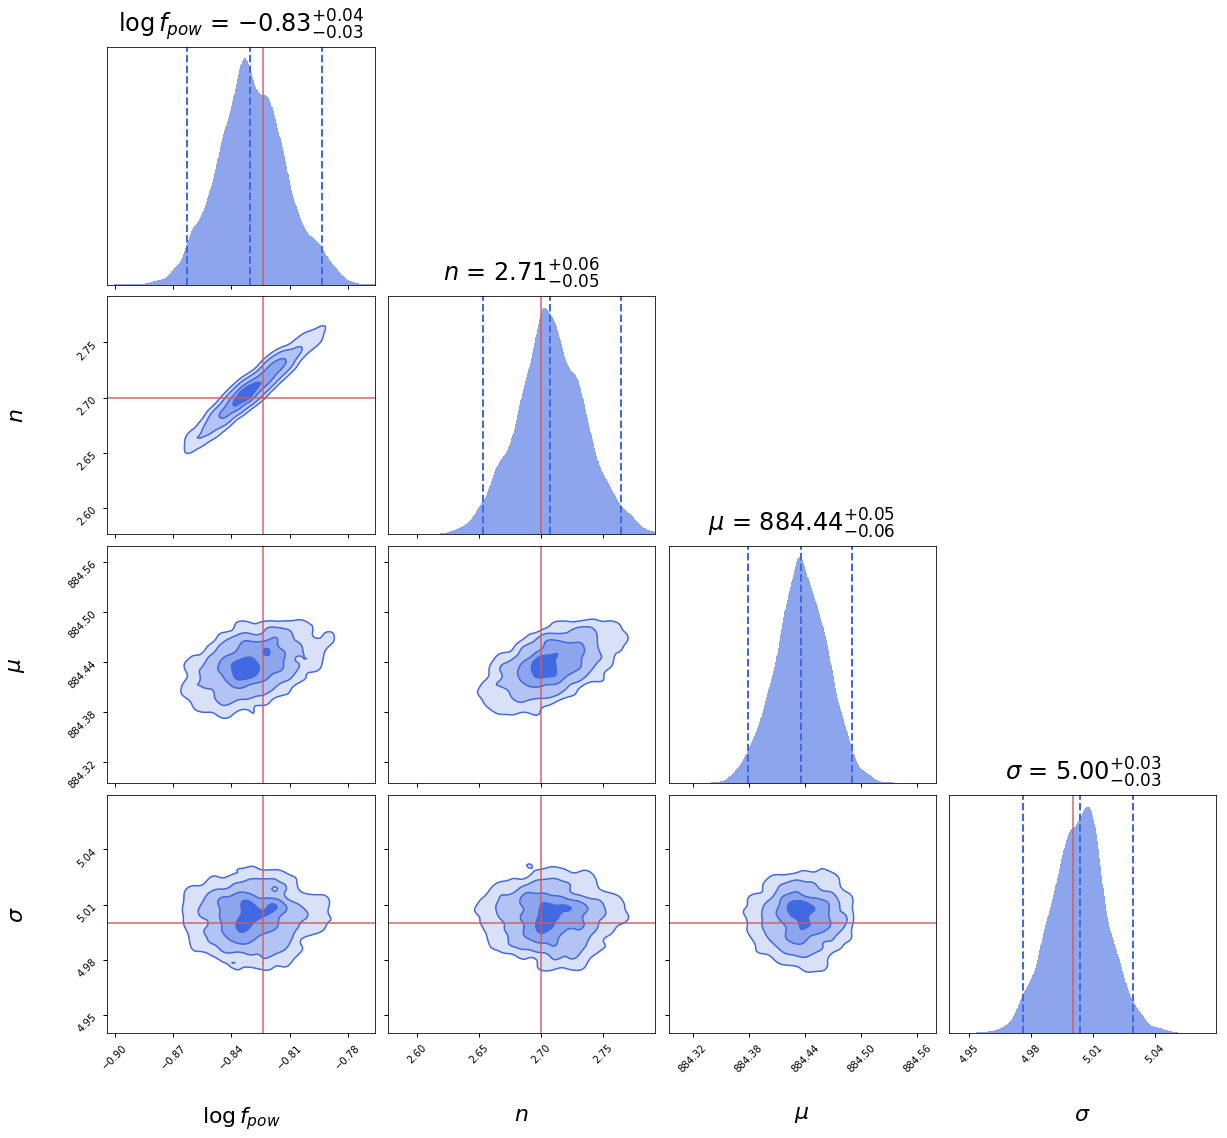

In [10]:
if RUN_FITTING:
    pdsampler = Run_Nested_Fitting(loglike, prior_transform, truths=truths)
    pdres = pdsampler.results

Fitting (mean):  [-8.29380673e-01  2.70763482e+00  8.84436221e+02  5.00286154e+00]
Fitting (median):  [-8.30211539e-01  2.70716610e+00  8.84435677e+02  5.00334882e+00]
Fitting (highest weight):  [-8.26656341e-01  2.71232430e+00  8.84438454e+02  5.00222017e+00]


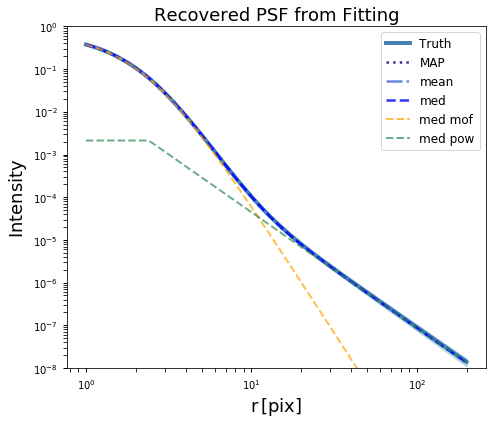

In [12]:
plot_fitting_vs_truth_PSF(pdres, n_bootsrap=500, image_size=image_size, save=False, dir_name=dir_name,
                              true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac, "n":n})

In [11]:
############################################
# Plotting Results
############################################

def plot_fitting_vs_truth_PSF(res, true_pars, image_size=image_size, 
                              n_bootsrap=100, save=False, dir_name="."):
    from dynesty import utils as dyfunc
    
    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    mean, cov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    med = np.median(samples_eq,axis=0)                    # median sample
    MAP = samples[weights.argmax()]                       # sample contributing most weights
    
    print("Fitting (mean): ", mean)
    print("Fitting (median): ", med)
    print("Fitting (highest weight): ", MAP)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootsrap)[0]
    
    gamma, alpha, frac, n = true_pars.values()
    
    C_pow1Dto2D = (n-2) / (n-1) / np.pi / theta_t_pix
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma, alpha=alpha)
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) * C_pow1Dto2D
    
    plt.figure(figsize=(7,6))
    
    plt.semilogy(r, (1-frac) * comp1 + frac * comp2,
                 label="Truth", color="steelblue", lw=4, zorder=2)
    for logfrac_k, n_k in zip(samples_eq_bs[:,0].T, samples_eq_bs[:,1].T):
        frac_k = 10**logfrac_k
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) * C_pow1Dto2D

        plt.semilogy(r, (1-frac_k) * comp1 + frac_k * comp2_k,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([MAP, med, mean], ["darkblue", "royalblue", "b"],
                                  [":","-.","--"], ["MAP", "mean", "med"]):
            f_fit = 10**fits[0]
            plt.semilogy(r, (1-f_fit) * comp1 + f_fit * trunc_power1d_normed(r, fits[1], theta_t_pix) * C_pow1Dto2D,
                 color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
        
        plt.semilogy(r, (1-f_fit) * comp1,
                 color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
        plt.semilogy(r, f_fit * trunc_power1d_normed(r, med[1], theta_t_pix)/C_pow2Dto1D,
                 color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
    
    plt.legend(fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(1e-8, 1)    
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()